In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
import time
import random
import pandas as pd

from scipy import signal
from scipy import misc
from scipy.spatial import distance

from ipywidgets import Image
from ipycanvas import Canvas

In [2]:
def random_color():
    levels = range(32,256,32)
    return tuple(random.choice(levels) for _ in range(3))

In [3]:
img = []
img4 = []
img_orig = []

### Load image

##### Insert white border around image

In [4]:
img = cv2.imread("map.png", cv2.IMREAD_GRAYSCALE);
backtorgb = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB);
img = backtorgb.dot([0.33,0.33,0.33])

(my,mx)=img.shape
img[0,:]=255
img[:,0]=255
img[my-1,:]=255
img[:,mx-1]=255

img_orig = img.copy()

image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)

### Process Image to find middle point between tracks

##### Difference between subsequent dilations

In [5]:
difftmp = np.array([[1,1,1],[1,0,1],[1,1,1]])
kernel = np.ones((3,3),np.uint8)
img4 = np.zeros_like(img)*0
clas = True
while clas == True:
    img2 = cv2.dilate(img,kernel,iterations = 1)
    img3 = img2-img
    if np.sum(img3)==0:
        break
    
    ### Calculate number of white pixels around this pixel
    img4 = img4+(signal.convolve2d(img3,difftmp, boundary='symm', mode='same')/255>4)*255
    
    image_data = np.stack((img3+img4,img3+img_orig,img3), axis=2)
    img = img2.copy()
image_data = np.stack((img4,img4+img3,img4), axis=2)

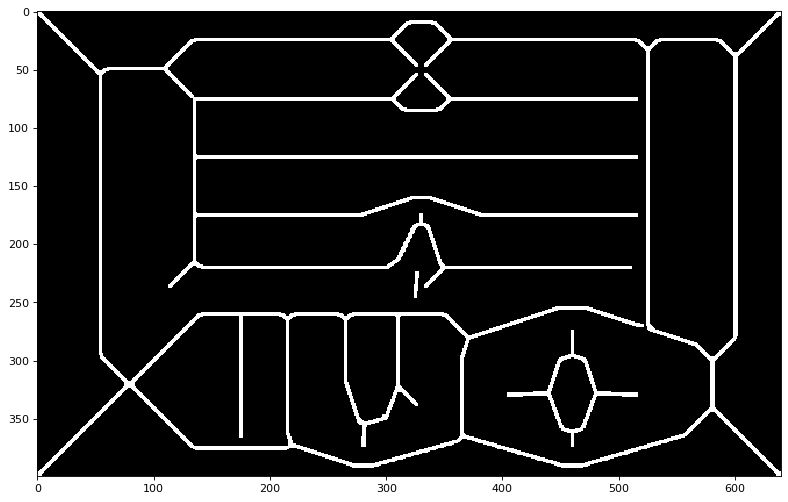

In [8]:
dst = image_data.copy()

kernel = np.ones((3,3),np.uint8)
img4 = cv2.dilate(img4,kernel,iterations = 1)
#img5 = cv2.morphologyEx(img5, cv2.MORPH_CLOSE, kernel)
#img4 = cv2.erode(img5,kernel,iterations = 1)


figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(img4, cmap='gray', vmin=0, vmax=255)
plt.show()

In [9]:
ret,thresh = cv2.threshold(img4.astype(np.uint8),127,255,0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

In [146]:
### Convert OpenCV contours to array of arrays
print(len(contours))
contour_map = []
for i in range(len(contours)):
    
    this_countour = []
    
    for a in contours[i]:
        [x,y]=a[0]
        this_countour.append((x,y))
    contour_map.append(this_countour)

10


In [155]:
#### Convert lines into array of lines in a grid
lengths = []
for i in range(len(contour_map)):
    for a in range(len(contour_map[i])-1):
        (sx,sy) = contour_map[i][a]
        (ex,ey) = contour_map[i][a+1]
        
        length = distance.euclidean((sx,sy),(ex,ey))
        if sx==ex:
            lengths.append([sx,sy,ex,ey,length,np.inf,i])
        else:
            if sx<ex:
                lengths.append([sx,sy,ex,ey,length,(ey-sy)/(ex-sx),i])
            else:
                lengths.append([ex,ey,sx,sy,length,(sy-ey)/(sx-ex),i])

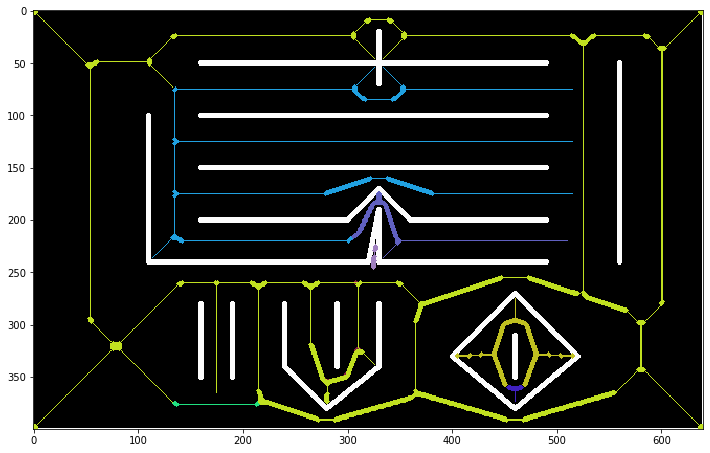

{0: (32, 224, 128), 1: (64, 32, 192), 4: (192, 192, 32), 5: (128, 32, 64), 6: (160, 128, 192), 7: (96, 96, 192), 8: (32, 160, 224), 9: (192, 224, 32)}


In [156]:
#### Show very small lines (shown in larger thickness)
#### Colour are of the same contour

image_data = np.stack((img_orig,img_orig,img_orig), axis=2).astype(np.uint8)

colr_dict={}
for i in lengths:
    [x,y,x1,y1,length,grad,cnmap]=i
    if cnmap in colr_dict:
        colourr = colr_dict[cnmap]
    else:
        colourr = random_color()
        colr_dict[cnmap] = colourr
        
    if length<10:
        cv2.line(image_data,(x,y),(x1,y1),colourr,3)
    else:
        cv2.line(image_data,(x,y),(x1,y1),colourr,1)
    
    
figure(num=None, figsize=(12, 10))
plt.imshow(image_data)
plt.show()
print(colr_dict)

### Summarize small bits to lines
Go through all contours

In [168]:
def closest_point(fp_list,fp):
    (x,y)=fp
    distance = 999999999
    (npx,npy) = (0,0)
    
    for (xx,yy) in fp_list:
        dist2 = (xx-x)**2+(yy-y)**2
        if dist2<distance:
            (npx,npy) = (xx,yy)
            dist2=distance
    return (npx,npy)

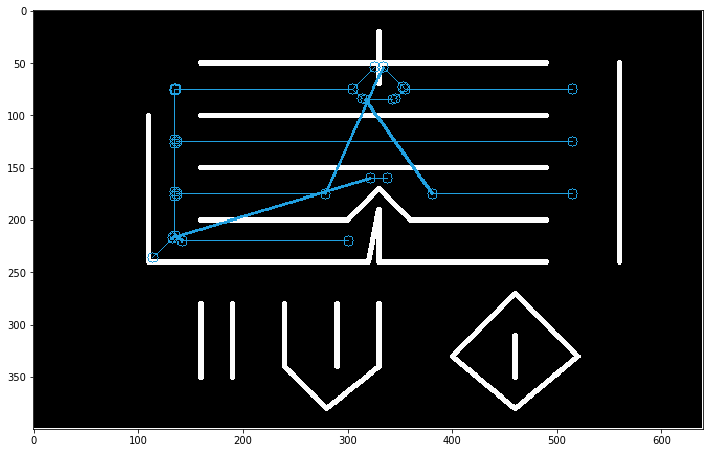

In [189]:
image_data = np.stack((img_orig,img_orig,img_orig), axis=2).astype(np.uint8)
for cnt_no in [1]: #set([i[6] for i in lengths]):
    
    f_points = []
    for cnt in lengths:
        [x,y,x1,y1,length,grad,cnmap]=cnt
        
        if cnmap==8: # cnt_no
            if length>10:
                f_points.append((x,y))
                f_points.append((x1,y1))
    f_points = list(set(f_points))
    
    for fp in f_points:
        (x1,y1)=fp
        cv2.circle(image_data,(x1,y1),5,colourr)
    
    for cnt in lengths:
        [x,y,x1,y1,length,grad,cnmap]=cnt
        
        
        if cnmap==8: # cnt_no
            colourr = colr_dict[cnmap]
            if length>10:
                cv2.line(image_data,(x,y),(x1,y1),colourr,1)
            #else:
            #    (xx,yy) = closest_point(f_points,x,y)
            #    (xx1,yy1) = closest_point(f_points,x1,y1)
            #    cv2.line(image_data,(xx,yy),(xx1,yy1),colourr,2)
            
    
    pairs = []
    nfp = f_points.copy()
    
    while (len(f_points)>0):
        lin1_point=f_points[0]
        
        nfp.remove(lin1_point)
        lin2_point = closest_point(nfp,lin1_point)
        
        nfp.remove(lin2_point)
        f_points.remove(lin1_point)
        f_points.remove(lin2_point)
        
        pairs.append([lin1_point,lin2_point])

for i in pairs[0::4]:
    [(x1,y1),(x2,y2)]=i
    cv2.line(image_data,(x1,y1),(x2,y2),colourr,2)

figure(num=None, figsize=(12, 10))
plt.imshow(image_data)
plt.show()
    

In [181]:
print(pairs[0:4])

[[(142, 220), (135, 215)], [(314, 84), (353, 73)], [(136, 75), (135, 127)], [(305, 75), (137, 125)]]


## combine small lines together
nl = []
for i in lengths:
    [psx1,psy1,pex1,pey1,pl,pg]=i
    found=False
    for j in lengths:
        if i!=j:
            [ssx1,ssy1,sex1,sey1,sl,sg]=j
            
            if distance.euclidean((ssx1,ssy1),(psx1,psy1))<2:
                found=True
                [x1,x2,y1,y2]=[sex1,sey1,pex1,pey1]
                break
                
            if distance.euclidean((sex1,sey1),(psx1,psy1))<2:
                found=True
                [x1,x2,y1,y2]=[ssx1,ssy1,pex1,pey1]
                break
                
            if distance.euclidean((ssx1,ssy1),(pex1,pey1))<2:
                found=True
                [x1,x2,y1,y2]=[sex1,sey1,psx1,psy1]
                break
                
            if distance.euclidean((sex1,sey1),(pex1,pey1))<2:
                found=True
                [x1,x2,y1,y2]=[ssx1,ssy1,psx1,psy1]
                break
    
    ## no close
    if not found:
        nl.append(i)
    else:
        length = distance.euclidean((x1,y1),(x2,y2))
        if x1>x2:
            nl.append([x2,y2,x1,y1,length,(y2-y1)/(x2-x1)])
        else:
            nl.append([x1,y1,x2,y2,length,(y1-y2)/(x1-x2)])
                
            

In [11]:
canvas2 = Canvas(width=mx, height=my)
canvas2

Canvas(height=400, width=640)

In [13]:
#### Remove lines that touch Tracks

for i in range(len(contour_map)):
    
    #cv2.drawContours(backtorgb, contours, i, random_color(), 3)
    first = True
    colourr = random_color()
    for a in contour_map[i]:
        (x,y)=a
        colourr = random_color()
        
        #print([x,y],sum(sum(img_orig[y-3:y+3,x-3:x+3])))
        minx=max(0,x-3)
        miny=max(0,y-3)
        maxx=min(mx,x+3)
        maxy=min(my,y+3)
        if sum(sum(img_orig[miny:maxy,minx:maxx]))<20:
            if first==True:
                first=False
                x1=x
                y1=y
            else:
                cv2.line(backtorgb,(x,y),(x1,y1),colourr,1)
                x1=x
                y1=y
            
                
        image_data = np.stack((backtorgb[:,:,0],backtorgb[:,:,1],backtorgb[:,:,2]), axis=2)
        canvas2.put_image_data(image_data,0,0)
        canvas2
        time.sleep(0.5)
    
    